In [7]:
import torch
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.models import ResNet18_Weights
from PIL import Image, UnidentifiedImageError
import matplotlib.pyplot as plt
import numpy as np
import requests
from io import BytesIO

# Load a pretrained ResNet-18 model using the updated weights parameter
model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
model.eval()

# Load and preprocess the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to ImageNet input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load ImageNet class labels
imagenet_classes_url = 'https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt'
response = requests.get(imagenet_classes_url)
imagenet_classes = response.text.strip().split('\n')

# Load image from URL with user-agent and error handling
image_url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/5/5c/Golden_retriever%2C_Argentina.jpg/220px-Golden_retriever%2C_Argentina.jpg'
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}
try:
    response = requests.get(image_url, headers=headers)
    response.raise_for_status()  # Check if request was successful
    img = Image.open(BytesIO(response.content)).convert('RGB')
except (requests.exceptions.RequestException, UnidentifiedImageError) as e:
    print(f"Failed to load image: {e}")
    exit()

# Preprocess the image
input_tensor = transform(img).unsqueeze(0)  # Add batch dimension

In [8]:
# Hook to capture gradients and activations
grads = None
activations = None

def save_gradient(module, grad_input, grad_output):
    global grads
    grads = grad_output[0]

def save_activation(module, input, output):
    global activations
    activations = output

# Register hooks on the last convolutional layer
final_conv = model.layer4[1].conv2  # Last convolutional layer in ResNet-18
final_conv.register_forward_hook(save_activation)
final_conv.register_backward_hook(save_gradient)

# Forward pass
output = model(input_tensor)
predicted_class = output.argmax().item()

# Print the predicted class label
predicted_label = imagenet_classes[predicted_class]
print(f"Predicted Class: {predicted_label}")

# Backward pass for the predicted class
model.zero_grad()
class_loss = output[0, predicted_class]
class_loss.backward()

# Compute Grad-CAM
weights = grads.mean(dim=(2, 3), keepdim=True)  # Global average pooling
cam = (weights * activations).sum(dim=1, keepdim=True)  # Weighted sum
cam = F.relu(cam)  # Apply ReLU

Predicted Class: golden retriever


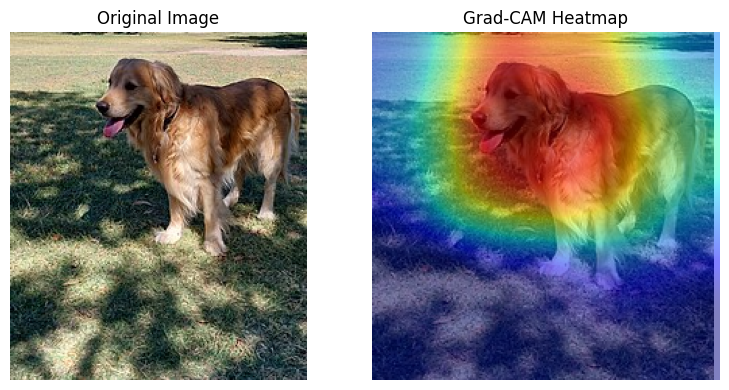

In [9]:
# Normalize and resize CAM to match input image
cam = cam.squeeze().detach().cpu().numpy()
cam = (cam - cam.min()) / (cam.max() - cam.min())  # Normalize between 0 and 1
cam = np.uint8(255 * cam)
cam = Image.fromarray(cam).resize((224, 224), Image.LANCZOS)

# Visualize Grad-CAM heatmap overlay
plt.figure(figsize=(8, 4))
# Original Image
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')
# Heatmap Overlay
plt.subplot(1, 2, 2)
plt.imshow(img)
plt.imshow(cam, cmap='jet', alpha=0.5)  # Overlay heatmap
plt.title('Grad-CAM Heatmap')
plt.axis('off')
plt.tight_layout()
plt.show()